# ML-based analysis of the TIA data

*Version: 2020-01-10*

Here we perform analysis on the data prepared according to Peter's suggestions related to variable selection (including Peter's flag) and imputation of missing values. The analysis covers the following aspects:
* data encoding (one-hot encoding for nominal variables) and then standard scaling (for numerical and encoded categorical features),
* visualization of data (learn and testing sets) -- this should give us better insights into data characteristics and allow for a more informed choice of classifiers (one-class vs. binary ones),
* application of preprocessing methods to address the severe imbalance of classes (~2.5% of casses in the positive/critical class),
* construction and evaluation of several selected classification models including optimization of hyperparameters).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np


## Reading and preparing the data set

Read the prepared data set, keep a single decision variable -- `my_outcome` (remove the other two) and apply one-hot encoding to symbolic variables.

In [2]:
df_all = pd.read_csv("../data/tia-ed-sel-imp-2020-01-09.csv", index_col=0)

In [3]:
df_all.head()

,my_outcome,adj_outcome_is7day,adj_carotidoutcome_is7day,sex_female,age,temperature,hr_rate,sbp,dbp,sa02,...,my_vertigo_syncope,my_lang_speech,my_afib,img_abn_l,img_abn_r,uni_weakness_l,uni_weakness_r,aphasia,peter_flag,learn
0,0,0,0.0,1,53.0,36.299988,70.0,121.0,79.0,99.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.0,1,81.0,36.500000,57.0,215.0,55.0,98.0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0.0,0,45.0,36.599976,66.0,151.0,95.0,98.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.0,0,54.0,35.199980,108.0,123.0,89.0,97.5,...,0,1,0,0,0,0,0,1,0,1
4,0,0,0.0,1,74.0,36.799988,110.0,119.0,79.0,98.0,...,0,1,1,0,0,0,1,0,0,1


In [4]:
# Remove unused decision variables
df_all.drop(columns=['adj_outcome_is7day', 'adj_carotidoutcome_is7day'], inplace=True)

Now we change the encoding of the `dursymptom` variable -- we move back from codes to numerical values. These codes can be ordered, therefore such approach is valid in this context.

In [5]:
df_all['dursymptoms_encoded'] = df_all.dursymptoms.map({'lt_1min': 0, '1_5min': 1, '5_9min': 2, '10_29min': 3, '30_59min': 4, 'ge_60min': 5})
df_all[['dursymptoms', 'dursymptoms_encoded']].drop_duplicates()

,dursymptoms,dursymptoms_encoded
0,ge_60min,5
1,5_9min,2
7,10_29min,3
10,1_5min,1
12,30_59min,4
63,lt_1min,0


In [6]:
# Now remove the old dursymptoms columns and rename dursymptoms_encoded to dursymptoms
df_all.drop(columns=['dursymptoms'], inplace=True)
df_all.rename(columns={'dursymptoms_encoded': 'dursymptoms'}, inplace=True)

In [7]:
# We also change the type of inittia_numpast from float to int
df_all.inittia_numpast = pd.to_numeric(df_all.inittia_numpast, downcast='integer')

In [8]:
# Introduce dummy variables
df_all_encoded = pd.get_dummies(df_all, drop_first=True)

In [9]:
# Split the data into learning and training subsets
df_train = df_all_encoded[df_all_encoded.learn == 1].drop(columns=['learn'])
df_test = df_all_encoded[df_all_encoded.learn == 0].drop(columns=['learn'])

In [11]:
df_train.columns.values

array(['my_outcome', 'sex_female', 'age', 'temperature', 'hr_rate', 'sbp',
       'dbp', 'sa02', 'wbcvalue', 'hgbvalue', 'pltvalue', 'creatinevalue',
       'glucosevalue', 'ckvalue', 'tntvalue', 'pmedhis_hyp',
       'pmedhis_cad', 'pmedhis_af', 'pmedhis_pvd', 'pmedhis_diab',
       'pmedhis_kps', 'pmedhis_smoker', 'pmedhis_cs', 'pmedhis_chf',
       'pmedhis_hchol', 'pmedhis_dem', 'pmedhis_vhd',
       'med_ibup_last_7days', 'my_infarct', 'inittia_numpast',
       'my_sensation', 'my_weakness', 'my_gait', 'my_vertigo_syncope',
       'my_lang_speech', 'my_afib', 'img_abn_l', 'img_abn_r',
       'uni_weakness_l', 'uni_weakness_r', 'aphasia', 'peter_flag',
       'dursymptoms', 'my_ecgtype_afib', 'my_ecgtype_afl',
       'my_ecgtype_conduction_abn', 'my_ecgtype_non_specific',
       'my_ecgtype_old_infarct', 'my_ecgtype_pace_rhythm',
       'my_ecgtype_sinus_rhythm', 'med_asa_discont_ed',
       'med_asa_started_ed', 'med_dipy_already_taken',
       'med_dipy_discont_ed', 'med_dipy_sta

In [11]:
df_test.head()

,my_outcome,sex_female,age,temperature,hr_rate,sbp,dbp,sa02,wbcvalue,hgbvalue,...,med_clop_already_taken,med_clop_discont_ed,med_clop_started_ed,med_stat_discont_ed,med_stat_started_ed,med_anti_discont_ed,med_anti_started_ed,med_coum_already_taken,med_coum_discont_ed,med_coum_started_ed
3954,0,1,85.0,37.099976,72.0,143.0,88.0,98.0,6.40,137.0,...,0,0,0,0,0,0,0,0,0,0
4465,0,0,63.0,36.500000,56.0,138.0,94.0,97.0,7.20,151.0,...,0,0,0,0,0,0,0,1,0,0
4605,0,0,74.0,36.599976,63.0,143.0,75.0,98.0,8.40,127.0,...,0,0,0,0,0,0,0,0,0,0
4827,0,0,74.0,36.199980,60.0,140.0,80.0,97.0,8.68,148.0,...,0,0,0,0,0,0,0,0,0,0
4870,0,0,72.0,36.899994,67.0,155.0,69.0,100.0,11.30,91.0,...,0,0,1,0,0,0,0,0,0,0


Now we apply standarization to all columns and store raw values for subsequent analysis.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [13]:
X_train = scaler.fit_transform(df_train.iloc[:, 1:].values)
y_train = df_train.iloc[:, 0].values
X_test = scaler.transform(df_test.iloc[:, 1:].values)
y_test = df_test.iloc[:, 0].values

## Visualize train and test data

In [14]:
import  matplotlib.pyplot as plt

def create_plot(X, y, title, size=(8*3,8)):
    colors, labels = ["green", "red"], ["negative", "positive"]
    fig = plt.gcf()
    fig.set_size_inches(size[0], size[1])
    for c in [0, 1]:
        X_c = X[y == c, :]
        plt.scatter(X_c[:, 0], X_c[:, 1], c=colors[c], alpha=0.3, label=labels[c])
    plt.title(title)
    plt.legend()

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def create_plot_3d(X, y, title, size=(8*3,8)):
    colors, labels = ["green", "red"], ["negative", "positive"]
    fig = plt.gcf()
    fig.set_size_inches(size[0], size[1])
    axs = [fig.add_subplot(131, projection="3d"), fig.add_subplot(132, projection="3d"), fig.add_subplot(133, projection="3d")]
    for c in [0, 1]:
        X_c = X[y == c, :]
        axs[c].scatter(X_c[:, 0], X_c[:, 1], X_c[:, 2], c=colors[c], alpha=0.3, label=labels[c])
        axs[2].scatter(X_c[:, 0], X_c[:, 1], X_c[:, 2], c=colors[c], alpha=0.3, label=labels[c])
    fig.suptitle(title)
    for ax in axs:
        ax.legend()

### Visualization with PCA

In order to get a better insight into the complexity of the data set (modality and overlap), as discussed in the paper by [Japkowicz et al.][1]. For this purpose we apply the PCA technique in order to visualize the learning and testing data set. This visualization is limited to 3 top principal components and their results are given below.

[1]: http://proceedings.mlr.press/v74/bellinger17a.html "Sampling a Longer Life: Binary versus One-class classification Revisited"

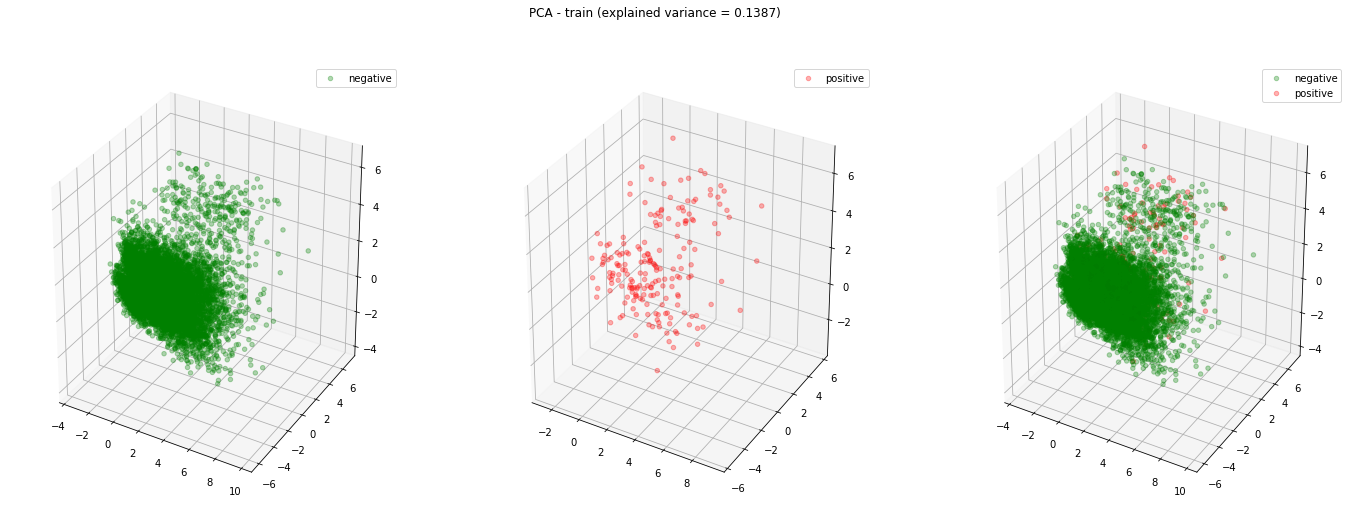

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)

for cohort, X, y in [('train', X_train, y_train), ('test', X_test, y_test)]:
    X_pca = pca.fit_transform(X) if cohort == 'train' else pca.transform(X)
    v = np.sum(pca.explained_variance_ratio_)
    if cohort == 'train':
        create_plot_3d(X_pca, y, f"PCA - {cohort} (explained variance = {v:.4f})")
        plt.show()

The results reval that the top 3 components capture a very limited amount of variability (13%, established for the training data set). This implies that a larger number of features is relevant for classification and that presented visualizations are only 'approximate'. The negative (majority) class seems to be multimodal -- there is a large and dense "cloud" in the bottom sourrounded and another one, more scattered, in the top (the structure of the positive class is somewhat similar).  Moreover, there as significant overlap between classes, especially in the bottom cloud. The observed multimodality in the negative class may imply thata combination of sampling and a binary classifier may lead to better performance than one-class learning methods. This will be explored in the subsequent analysis.

### Evaluation of feature importance

To obtain a better insight into the importance of specific features we apply mutual information which measures the depenency between a given feature and the outcome. It is important to note this method is idenpendent of classification -- i.e., we do not construct any classifier and check the importance of features in this classifier, but focus on the training data.

[1]: https://arxiv.org/abs/1711.08477 "Benchmarking Relief-Based Feature Selection Methods for Bioinformatics Data Mining"

In [17]:
feature_names = list(df_train.columns[1:])
feature_types = df_all_encoded.dtypes[feature_names]

In [18]:
from sklearn.feature_selection import mutual_info_classif

feature_scores = mutual_info_classif(X_train, y_train, discrete_features=list(feature_types != np.float64))
names_scores = {n: s for s, n in sorted(zip(feature_scores, feature_names), reverse=True)}


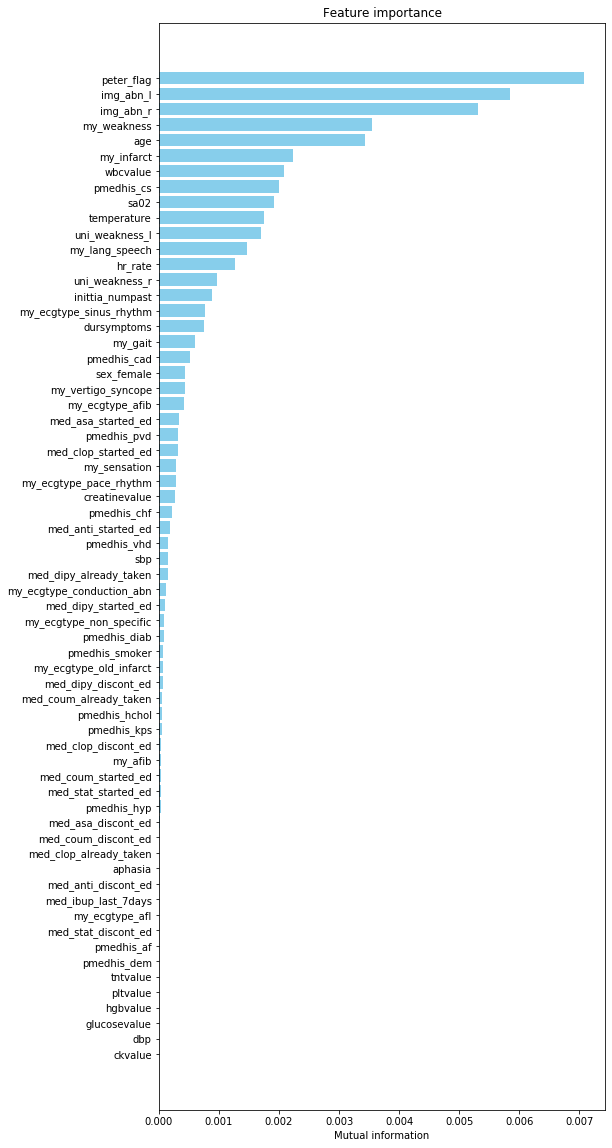

In [19]:
y_pos = np.arange(len(names_scores))
# bar_colors = ['limegreen' if s > 0.03 else 'seagreen' if s > 0.015 else 'skyblue' if s > 0.0075 else 'red' for s in selected_scores]
fig, ax = plt.subplots(figsize=(8, 20))
ax.barh(y_pos, list(names_scores.values()), color='skyblue', align='center')
plt.yticks(y_pos, names_scores.keys())
ax.set_xlabel("Mutual information")
ax.set_title("Feature importance")
ax.invert_yaxis()
plt.show()

It seems the most relevant features is `peter_flag` and abnormality indicators for imaging tests. Moreover, it seems that features related to the left side (both for imaging tests and weakness) are more important than their counterparts for the right side. There are also features that according to mutual information can be seen as irrelevant -- they are listed below (they all correspond to lab results).

In [20]:
[n for n, s in names_scores.items() if s == 0]

['tntvalue', 'pltvalue', 'hgbvalue', 'glucosevalue', 'dbp', 'ckvalue']

https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

## Perform evaluation of selected preprocessing methods and classifcation algorithms
We start with evaluating selected preprocessing and classification methods with default values of paramters (no optimization involved). In particular, we apply preprocessing methods to the development/learning set, build a classifier using preprocessed data and then evaluate it on the validation/testing set. We use AUC (area under the ROC curve as our primary evaluation measure). We consider the following preprocessing methods:
* no preprocessing (none),
* random undersampling (RU),
* random oversampling (RO),
* neighborhood cleaning rule (NCR) - a focused undersampling method.

Moreover, we employ the following classifiers:
* AdaBoost with simple decision trees (AD),
* logistic regression (LR),
* support vector machine with a linear kernel (LSVC),
* support vector machine with an RBF kernel (SVC),
* random forest (RF),
* extrem gradient boosting trees (XBG).



In [21]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score

In [22]:
class NoneSampler(object):
    def sample(self, X, y):
        return X, y
    
    def fit(self, X, y):
        return self
    
    def fit_resample(self, X, y):
        return self.sample(X, y)

In [23]:
samplers = {
#     "None": NoneSampler(),
    "RU": RandomUnderSampler(random_state=42),
    # "SMOTE": SMOTE(random_state=42),
    # "BSMOTE": BorderlineSMOTE(random_state=42),
    # "SMOTEENN": SMOTEENN(random_state = 42),
    # "NCR": NeighbourhoodCleaningRule(),
    "RO": RandomOverSampler(random_state=42),
    "ADASYN": ADASYN(random_state=42)
}

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

In [25]:
classifiers = { 
#     "1NN": KNeighborsClassifier(1), 
#     "3NN": KNeighborsClassifier(3), 
#     "AB": AdaBoostClassifier(random_state=42),
#     "DT-G": DecisionTreeClassifier(random_state=42, max_depth=10),
#     "DT-H": DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=10),
    "LR": LogisticRegression(random_state=42, solver='lbfgs', max_iter=500),
    "RF": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5),
#     "SVC": SVC(random_state=42, probability=True, gamma='auto'),
#     "LSVC": SVC(random_state=42, kernel='linear', probability=True, class_weight='balanced'),
#     "XGB": XGBClassifier(random_state=42)
}

In [26]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [27]:
def validate_one_class(clf, X_test, y_test, X_train = None):
    """Fits and evaluates a one-class classifier on a holdout sample"""
    if not (X_train is None):
        clf.fit(X_train)
    y_df = clf.decision_function(X_test)
    y_prob = np.max(y_df) - y_df
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    return (auc, fpr, tpr)

In [28]:
import pickle

def validate(name, clf, X_test, y_test, X_train = None, y_train = None):
    """Fits and evaluates a classifier on a holdout sample"""
    if not (X_train is None or y_train is None):
        clf.fit(X_train, y_train)
    pickle.dump(clf, open(f'{name}test.sav', 'wb'))
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    print(accuracy_score(y_test, y_pred))

In [29]:
def plot_roc_curves(results, size=(10, 10)):
    "Plots ROC curves based on the stored results"
    fig = plt.figure()
    fig.set_size_inches(size[0], size[1])
    # Plot specific curves
    for sampler_label, classifier_label, auc, fpr, tpr in results:
#         plt.plot(mean_fpr, mean_tpr, label=r'{} AUC={:.3f}$\pm${:.3f}'.format(label, mean_auc, std_auc))
        plt.plot(fpr, tpr, label='{}+{} AUC={:.3f}'.format(sampler_label, classifier_label, auc))

    # Plot common elements
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR (1 - TNR)')
    plt.ylabel('TPR')
    plt.title('ROC curves')
    plt.legend(loc='lower right')
    plt.show()

In [30]:
import seaborn as sns

def plot_heat_maps(results):
    df_results = pd.DataFrame(columns=['Sampler', 'Classifier', 'AUC'])
    for sampler_label, classifier_label, auc, _, _ in results:
        df_results.loc[len(df_results)] = [sampler_label, classifier_label, auc]
    
    f, ax = plt.subplots(figsize=(12, 4))
    ax.set_title("AUC")
    data = df_results.pivot("Sampler", "Classifier", "AUC")
    ax = sns.heatmap(data, annot=True, fmt=".3f", cmap="RdYlGn")
#         ax.set_title('AUC')    
    plt.show()

In [31]:
from imblearn.pipeline import make_pipeline

In [32]:
results = []
for classifier_label, classifier in classifiers.items():
    for sampler_label, sampler in samplers.items():     
        print(classifier_label)
        pipeline = make_pipeline(sampler, classifier)
        validate(classifier_label, pipeline, X_test, y_test, X_train, y_train)

LR
0.7023901310717039
LR
0.7941403238242097
LR
0.7656129529683886
RF
0.7555898226676947
RF
0.9043947571318427
RF
0.9154459007967104


Below we present results obtained for various combinations of features, preprocessing methods (samplers) and classifiers. Below we report major observations:
* best performance is obtained for top 25% and top 50%, adding more features in most cases deteriorates the classification performance,
* contrary to expectations, preprocessing methods in most cases have limited impact on the classification performance; moreover, random oversampling (RO) works better than undersampling (both random and focused - RU and NCR),
* AB and XGB classifiers demonstrated poorer performance than the remaining ones. Morever, when more features are considered, XGB seems to outperform AB.

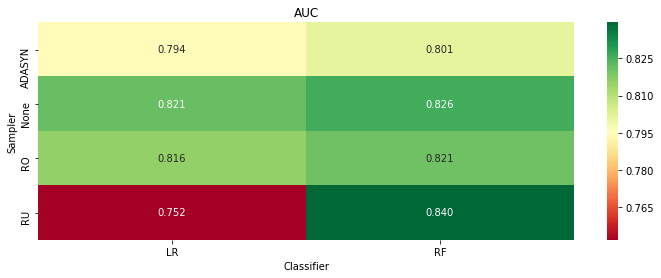

In [32]:
# plot_roc_curves(results)
plot_heat_maps(results)

### Using one-class learning
In this section we check the performance of one class classifiers (OneClassSVM and ...).

In [57]:
from sklearn.svm import OneClassSVM

In [58]:
outlier_ratio = np.sum(y_train == 1)/len(y_train)

In [59]:
outlier_ratio

0.025338059603518447

In [60]:
clf = OneClassSVM(kernel='rbf', nu=outlier_ratio, gamma=0.000001) 
X_train_0 = X_train[y_train == 0, :]
results.append(('None', 'OCSVM') + validate_one_class(clf, X_test, y_test, X_train_0))

In [61]:
X_train_0 = X_train[y_train == 0, :]
for g in np.logspace(-5, -10, 6, base=10.0):
    clf = OneClassSVM(kernel='rbf', nu=outlier_ratio, gamma=g) 
    results.append(('None', f'OCSVM{g}') + validate_one_class(clf, X_test, y_test, X_train_0))

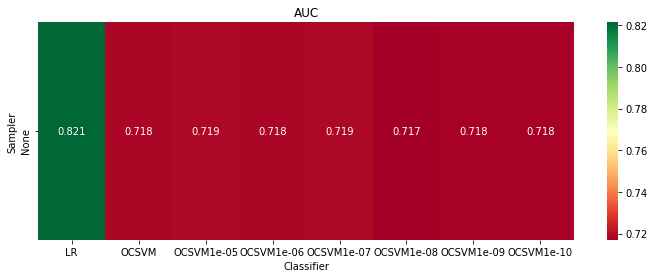

In [62]:
plot_heat_maps(results)

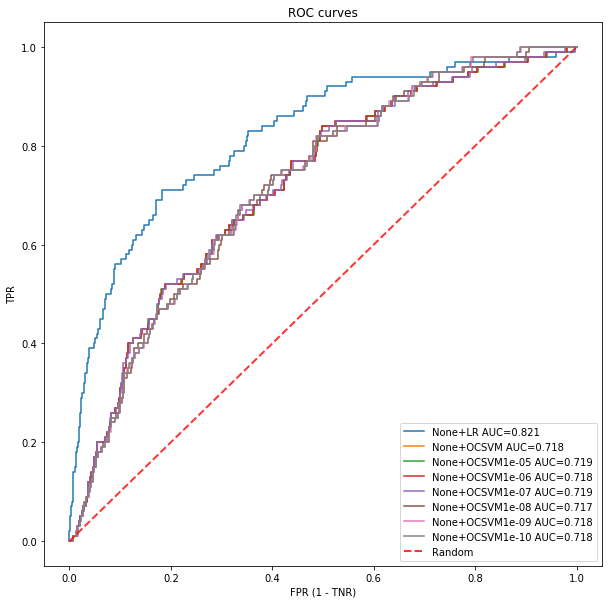

In [63]:
plot_roc_curves(results)

In [64]:
from sklearn.ensemble import IsolationForest

In [65]:
clf = IsolationForest(behaviour='new', contamination='auto', random_state=42) 
results.append(('None', 'IF') + validate_one_class(clf, X_test, y_test, X_train_0))

c:\users\kapis\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


AttributeError: 'IsolationForest' object has no attribute '_validate_data'

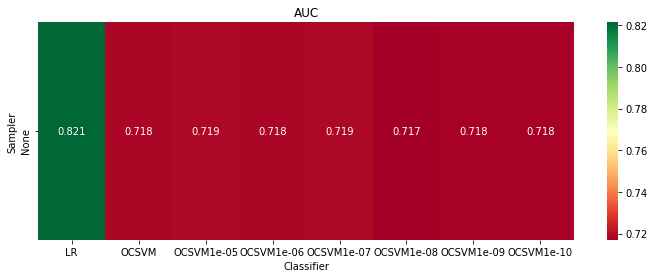

In [66]:
plot_heat_maps(results)

### Optimization of classifier parameters

Here we perform optimization of selected relevant parameters of classifiers using grid search. In this approach many variants of a given classifier are constructed and evaluated following the cross-validation scheme applied to the learning set. Then, the best variant of the classifier is selected and applied to the testing set (it is important to stress that testing data is not used during the optimization phase). Given the results reported in the previous section we exclude the AB classifier, focus on top 25% and top 50% features and use RO or no preprocessing.

In [67]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

In [68]:
results_optim = []
classifiers_optim = []

In [69]:
selected_samplers = {
    'None': samplers['None'],
    'RO': samplers['RO'],
    'RU': samplers['RU'],
}

#### Logistic regression

In [70]:
param_grid = { 'clf__C': np.logspace(-3, 3, 7, base=10.0) }

In [71]:
selected_samplers = {
    'None': samplers['None'],
    'RO': samplers['RO']
    # 'RU': samplers['RU'],
}

In [72]:
for sampler_label, sampler in selected_samplers.items():
    pipeline = Pipeline(steps=[('sampler', sampler), ('clf', classifiers['LR'])])
    searcher = GridSearchCV(pipeline, param_grid, scoring='roc_auc', n_jobs=-1, cv=10, verbose=1)
    searcher.fit(X_train, y_train)
    clf = searcher.best_estimator_
    results_optim.append((sampler_label, 'LR') + validate(clf, X_test, y_test))
    classifiers_optim.append((sampler_label, 'LR', clf))

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.8s finished


AttributeError: 'RandomOverSampler' object has no attribute '_validate_data'

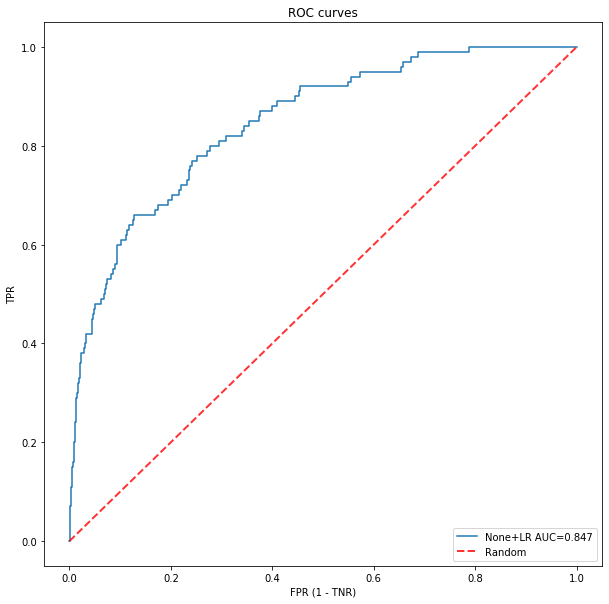

In [73]:
plot_roc_curves(results_optim)

#### SVC with an RBF kernel

In [74]:
param_grid = {
    'clf__C': np.logspace(-3, 3, 7, base=10.0),
    'clf__gamma' : np.logspace(-2, 2, 5, base=10.0)
}


In [75]:
selected_samplers = {
    'None': samplers['None'],
    # 'RO': samplers['RO'],
    'RU': samplers['RU'],
}

In [76]:
    for sampler_label, sampler in selected_samplers.items():
        pipeline = Pipeline(steps=[('sampler', sampler), ('clf', classifiers['SVC'])])
        searcher = GridSearchCV(pipeline, param_grid, scoring='roc_auc', n_jobs=-1, cv=10, verbose=1)
        searcher.fit(X_train, y_train)
        clf = searcher.best_estimator_
        results_optim.append((sampler_label, 'SVC') + validate(clf, X_test, y_test))
        classifiers_optim.append((sampler_label, 'SVC', clf))

KeyError: 'SVC'

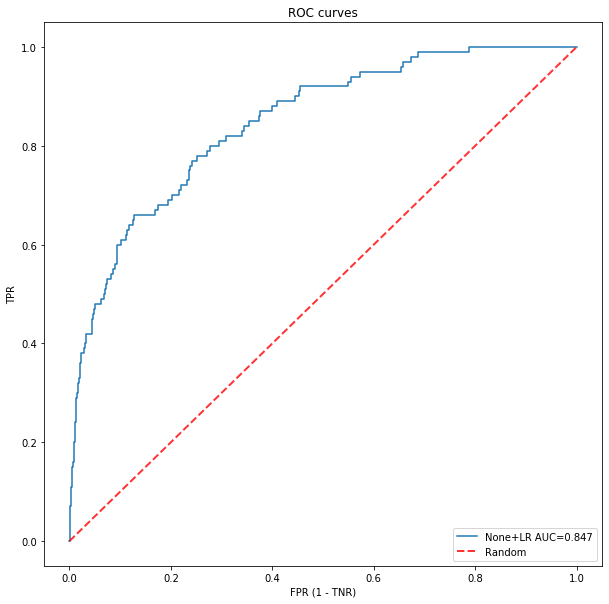

In [77]:
plot_roc_curves(results_optim)

#### Random forest

In [78]:
param_grid = {
    "clf__n_estimators": [10, 20, 50, 100, 200, 400, 600, 800, 1000], 
    "clf__max_depth": [3, 5, 10]
}

In [79]:
selected_samplers = {
    'None': samplers['None'],
    'RO': samplers['RO'],
    'RU': samplers['RU'],
}

In [80]:
for sampler_label, sampler in selected_samplers.items():
    pipeline = Pipeline(steps=[('sampler', sampler), ('clf', classifiers['RF'])])
    searcher = GridSearchCV(pipeline, param_grid, scoring='roc_auc', n_jobs=-1, cv=10, verbose=1)
    searcher.fit(X_train, y_train)
    clf = searcher.best_estimator_
    results_optim.append((sampler_label, 'RF') + validate(clf, X_test, y_test))
    classifiers_optim.append((sampler_label, 'RF', clf))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.1min finished


AttributeError: 'RandomForestClassifier' object has no attribute '_validate_data'

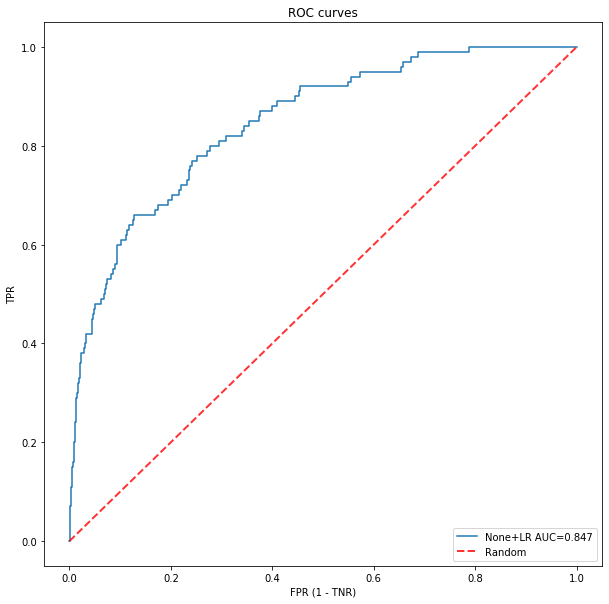

In [81]:
plot_roc_curves(results_optim)

#### XGB

In [0]:
param_grid = {
    "clf__n_estimators": [10, 20, 50, 100, 200, 300, 400, 600, 800, 1000], 
    "clf__learning_rate": np.logspace(-5, -1, 5, base=2.0),
    "clf__max_depth": np.arange(2, 8, 1)
}

In [0]:
selected_samplers = {
    'None': samplers['None'],
    # 'RO': samplers['RO'],
    'RU': samplers['RU'],
}

In [0]:
for sampler_label, sampler in selected_samplers.items():
pipeline = Pipeline(steps=[('sampler', sampler), ('clf', classifiers['XGB'])])
    searcher = GridSearchCV(pipeline, param_grid, scoring='roc_auc', n_jobs=-1, cv=10, verbose=1)
    searcher.fit(X_train, y_train)
    clf = searcher.best_estimator_
    results_optim.append((sampler_label, 'XGB') + validate(clf, X_test, y_test))
    classifiers_optim.append((sampler_label, 'XGB', clf))

In [0]:
plot_roc_curves(results_optim)

Results of this phase of the analysis are presented below. The main findings are as follows:
* parameter optimization improves performance for selectred combinations of feature sets, prepocessing methods and classifiers, however, their performance is similar,
* best performance is observed for LR and LSVC constructed using top 25% of features without preprocessing and for RF based on top 50% and oversampled (RO) data. 

In [ ]:
plot_roc_curves(results_optim)

In [ ]:
plot_heat_maps(results_optim)